# Analysis of Seattle Airbnb Data from 2016

![AI Rendering](seattle4.png "Image generated with https://huggingface.co/spaces/black-forest-labs/FLUX.1-dev")

Airbnb has released a lot of its data. The data analyzed in this evaluation comes from 
https://www.kaggle.com/datasets/airbnb/seattle/data
and is available in the public domain under CC0.

The evaluation can be viewed:
* [without Python code](index.html)
* [with Python code](seattle_airbnb.html)


## Inhaltsverzeichnis



1. [Beschreibung der DataFrames und ihrer Spalten](#beschreibung-der-dataframes-und-ihrer-spalten)
1. [Sind die Preise vom Stadtteil abhängig?](#sind-die-preise-vom-stadtteil-abhaengig)
1. [Gibt es eine Abhängigkeit der Preise von Feiertagen?](#gibt-es-eine-abhaengigkeit-der-preise-von-feiertagen)
1. [Haben erfahrene Hosts mit mehreren Angeboten bessere Bewertungen?](#haben-erfahrene-hosts-mit-mehreren-angeboten-bessere-bewertungen)




In [5]:
# Import libraries

import pandas as pd  # Import pandas for data analysis
import numpy as np  # Import NumPy for numerical operations
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
import holidays  # Import holidays for holiday data
import seaborn as sns  # Import seaborn for data visualization
import geopandas as gpd  # Import geopandas for geospatial data analysis
import geodatasets as gd  # Import geodatasets for geospatial data analysis


# read data
calendar = pd.read_csv('./data/calendar.csv')
listings = pd.read_csv('./data/listings.csv')
reviews = pd.read_csv('./data/reviews.csv')

# First look into the Data

## Description of DataFrames and their Columns

### calendar DataFrame

The table contains information about the availability and prices of Airbnb listings in Seattle for each calendar day in 2016.

### listings DataFrame

The data contains information about Airbnb listings in Seattle. They include details about the listings themselves, such as ID, URL, name, description, location (street, city, state, zip code, coordinates), and type of accommodation (e.g., room or property type, number of bedrooms and beds, amenities, price, and availability). Additionally, there is information about the hosts, such as their ID, name, location, verifications, and ratings. Reviews and feedback on the listings are also captured, including the number of reviews and various rating criteria (e.g., cleanliness, communication). Other columns concern booking conditions and guest requirements.

### reviews DataFrame

The table contains written reviews of the Airbnb listings with the reviewer's ID and a date. No numerical ratings are included.




# Is there a dependency of prices on holidays?

For this analysis, we need to combine the data from the calendar dataframe with the public holiday information for the US state of Washington (WA). We want to compare the prices on all days before a holiday or weekend day with the remaining prices.

Do accommodations become more expensive when you can sleep in the next day?

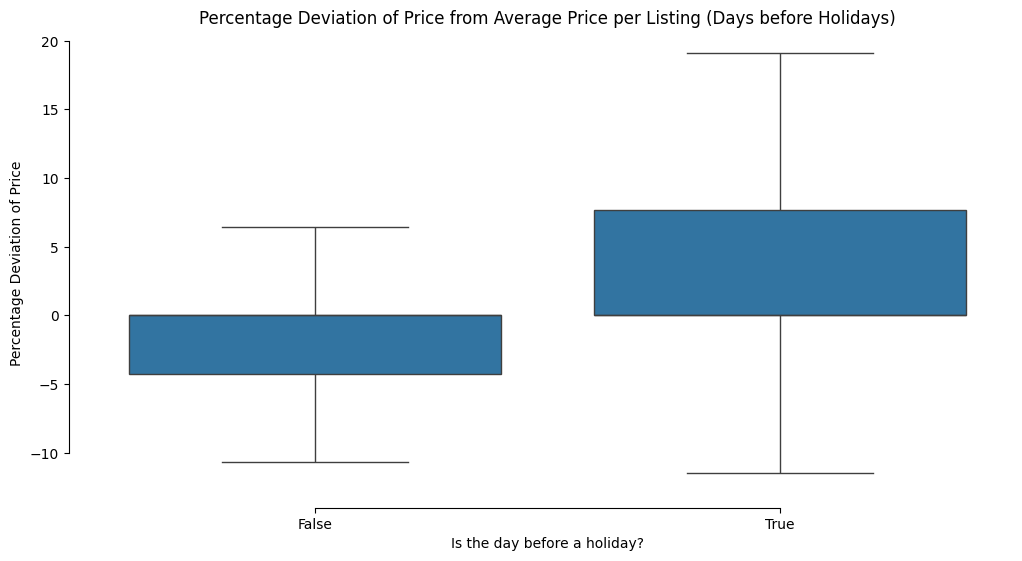

In [6]:

# Prepare the CSV data
calendar['_price'] = calendar['price'].replace('[\\$,]', '', regex=True).astype(float)
calendar['_date'] = pd.to_datetime(calendar['date'])
calendar['_available'] = calendar['available'].map({'t': True, 'f': False})

# Calculate the average price per listing (pandas automatically ignores NaN values)
average_price_per_listing = calendar.groupby('listing_id')['_price'].mean().reset_index()
average_price_per_listing.columns = ['listing_id', 'average_price']

# Merge the calculated average prices with the original DataFrame
calendar = calendar.merge(average_price_per_listing, on='listing_id', how='left')

# Calculate the price deviation from the average price per listing
calendar['price_deviation'] = calendar['_price'] - calendar['average_price']

# Calculate the percentage deviation of the price from the average price per listing
calendar['price_deviation_percentage'] = calendar['price_deviation'] / calendar['average_price'] * 100

# Function to check if a date is a holiday
us_holidays = holidays.US(state='WA')

def is_holiday(date):
    return date in us_holidays

# Create a column indicating whether the date is a holiday or weekend
calendar['is_holiday_or_weekend'] = calendar['_date'].apply(lambda x: x.weekday() >= 5 or is_holiday(x))

# Create a boolean column indicating whether the date is the day before a holiday
calendar['is_day_before_holiday'] = calendar['is_holiday_or_weekend'].shift(-1)
# Replace NaN values in the last row with True (January 1st is a holiday)
with pd.option_context('future.no_silent_downcasting', True):
    calendar['is_day_before_holiday'] = calendar['is_day_before_holiday'].fillna(True).infer_objects()

# Create two candlestick charts. Percentage deviation of the price from the average price per listing separated by is_day_before_holiday.
plt.figure(figsize=(12, 6))
# Hide outliers
sns.boxplot(x='is_day_before_holiday', y='price_deviation_percentage', data=calendar, showfliers=False)
sns.despine(offset=10, trim=True)
plt.title('Percentage Deviation of Price from Average Price per Listing (Days before Holidays)')
plt.xlabel('Is the day before a holiday?')
plt.ylabel('Percentage Deviation of Price')
plt.show()




In the chart, you can see that the deviation from the average price (per listing) is significantly higher before a holiday than when the following day is a regular workday.

Before a workday, discounts are common, while before a holiday/weekend, price increases of around 5% are observed.

# Are prices dependent on the neighborhood?

By merging the values from the calendar dataframe and the listings dataframe, we can calculate the average price per neighborhood.

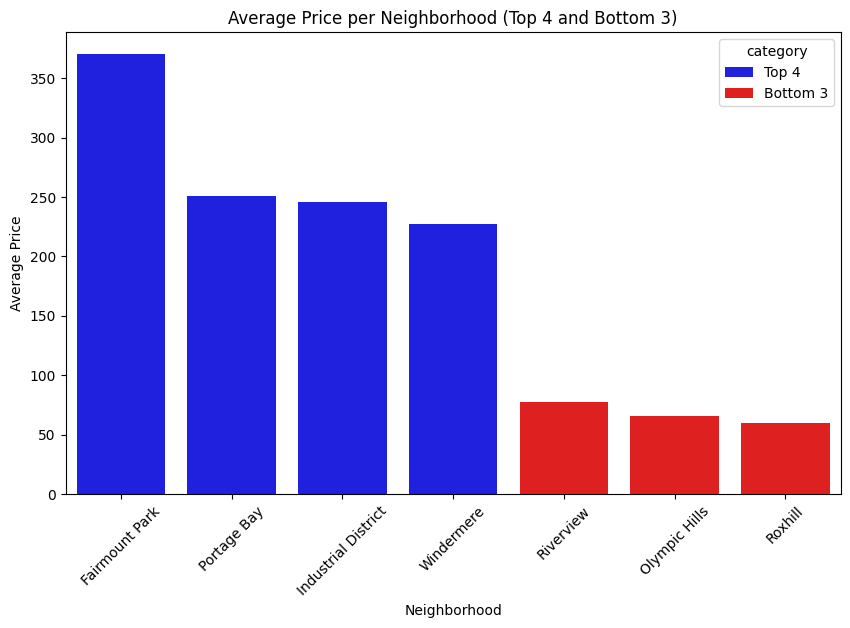

In [7]:
# Clean the price column in the calendar DataFrame and convert to float
calendar['price'] = calendar['price'].replace('[\\$,]', '', regex=True).astype(float)

# Merge the calendar and listings DataFrames on listing_id
merged_df = pd.merge(calendar, listings[['id', 'neighbourhood']], left_on='listing_id', right_on='id', how='left')

# Calculate the average price per neighborhood
average_price_per_neighbourhood = merged_df.groupby('neighbourhood')['price'].mean().reset_index()
average_price_per_neighbourhood.columns = ['neighbourhood', 'average_price']

# Sort neighborhoods by average price
sorted_neighbourhoods = average_price_per_neighbourhood.sort_values(by='average_price', ascending=False)

# Select the top 4 and bottom 3 neighborhoods
top_4_neighbourhoods = sorted_neighbourhoods.head(4)
bottom_3_neighbourhoods = sorted_neighbourhoods.tail(3)

# Combine the selected neighborhoods
selected_neighbourhoods = pd.concat([top_4_neighbourhoods, bottom_3_neighbourhoods])

# Create a bar plot with different colors for top 4 and bottom 3 neighborhoods
plt.figure(figsize=(10, 6))
colors = ['blue'] * 4 + ['red'] * 3
selected_neighbourhoods['category'] = ['Top 4'] * 4 + ['Bottom 3'] * 3
sns.barplot(x='neighbourhood', y='average_price', hue='category', data=selected_neighbourhoods, dodge=False, palette={'Top 4': 'blue', 'Bottom 3': 'red'})
plt.title('Average Price per Neighborhood (Top 4 and Bottom 3)')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()


The prices in the different neighborhoods of Seattle vary significantly. By far the most expensive accommodations are in Fairmount Park.

# Do experienced hosts with multiple listings have better ratings?

If hosts offer multiple accommodations, they should be able to gain experience and better tailor the offerings to the needs of visitors.

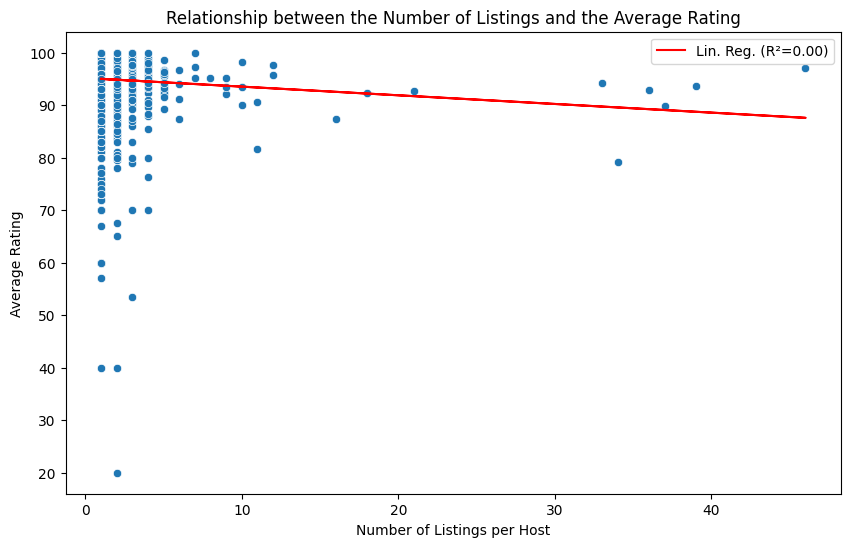

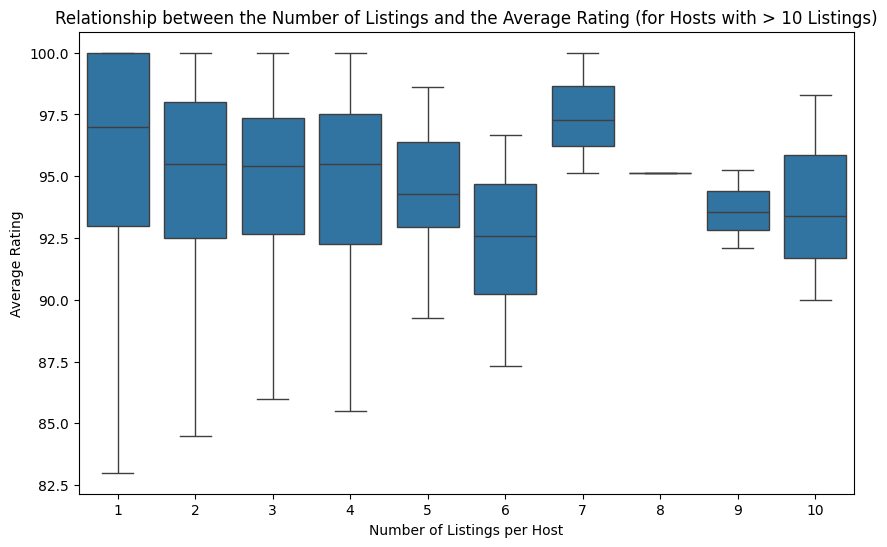

In [8]:
# Calculate the number of listings per host
listings_per_host = listings.groupby('host_id').size().reset_index(name='listings_count')

# Calculate the average rating per host
average_rating_per_host = listings.groupby('host_id')['review_scores_rating'].mean().reset_index(name='average_rating')

# Merge the DataFrames listings_per_host and average_rating_per_host on host_id
listings_and_ratings = pd.merge(listings_per_host, average_rating_per_host, on='host_id', how='left')

# Calculate the linear regression to approximate the relationship between the number of listings and the average rating
from scipy.stats import linregress

# Remove NaN values
listings_and_ratings_clean = listings_and_ratings.dropna(subset=['average_rating'])

# Calculate linear regression
slope, intercept, r_value, p_value, std_err = linregress(listings_and_ratings_clean['listings_count'], listings_and_ratings_clean['average_rating'])

# Create scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='listings_count', y='average_rating', data=listings_and_ratings_clean)
plt.plot(listings_and_ratings_clean['listings_count'], intercept + slope * listings_and_ratings_clean['listings_count'], 'r', label=f'Lin. Reg. (R²={r_value**2:.2f})')

plt.title('Relationship between the Number of Listings and the Average Rating')
plt.xlabel('Number of Listings per Host')
plt.ylabel('Average Rating')
plt.legend()
plt.show()

# Filter the data to include only hosts with more than 10 listings
filtered_data = listings_and_ratings_clean[listings_and_ratings_clean['listings_count'] <= 10]

# Create box plot for filtered data
plt.figure(figsize=(10, 6))
sns.boxplot(x='listings_count', y='average_rating', data=filtered_data, showfliers=False)
plt.title('Relationship between the Number of Listings and the Average Rating (for Hosts with > 10 Listings)')
plt.xlabel('Number of Listings per Host')
plt.ylabel('Average Rating')
plt.show()


The average rating does not seem to have an obvious correlation with the number of listings per host. Low ratings seem to increase with the number of listings. However, the average rating even slightly decreases (red regression line). Especially for hosts with many listings (>10), the data is quite sparse and the significance is questionable.